## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2024

# ECBM E4040 - Project - Deep Cluster

## Import Modules

In [1]:
%matplotlib inline
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, Model, Sequential, layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.datasets import cifar10
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Deep Cluster

![pipeline overview](figures/pipeline.png)

The Deep Cluster model works as above.

## 1. Load Data

In [2]:
# Load the Cifar10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Data organizations:
# Train data: 40000 samples from original train set: 1~40000
# Validation data: 1000 samples from original train set: 40001~50000
# for simplicity, spilt later

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

num_classes = len(np.unique(y_train))
print("Number of classes: {}".format(num_classes))

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)
Number of classes: 10


### Visualize some original images

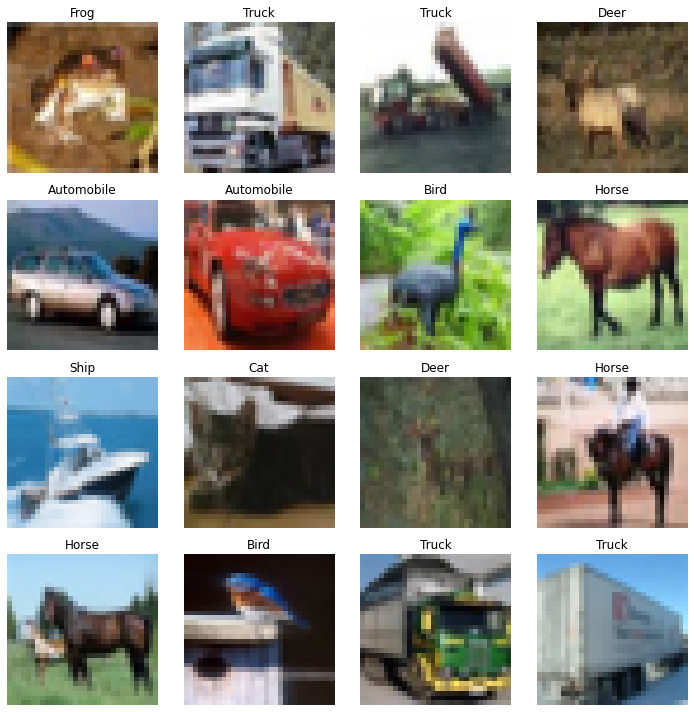

In [3]:
from utils.data_processing import plot_cifar10

# CIFAR-10 class labels
cifar10_labels = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

# Visualize images from the training set
plot_cifar10(X_train, y_train, cifar10_labels)

### Data preprocessing

In [4]:
from utils.data_processing import data_augmentation, preprocess_data

# Convert the data to grayscale
X_train_gray = tf.image.rgb_to_grayscale(X_train)
X_test_gray = tf.image.rgb_to_grayscale(X_test)

# Preprocess images
X_train, y_train = preprocess_data(X_train_gray, y_train)
X_test, y_test = preprocess_data(X_test_gray, y_test)

# Construct training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(data_augmentation).batch(256).shuffle(1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


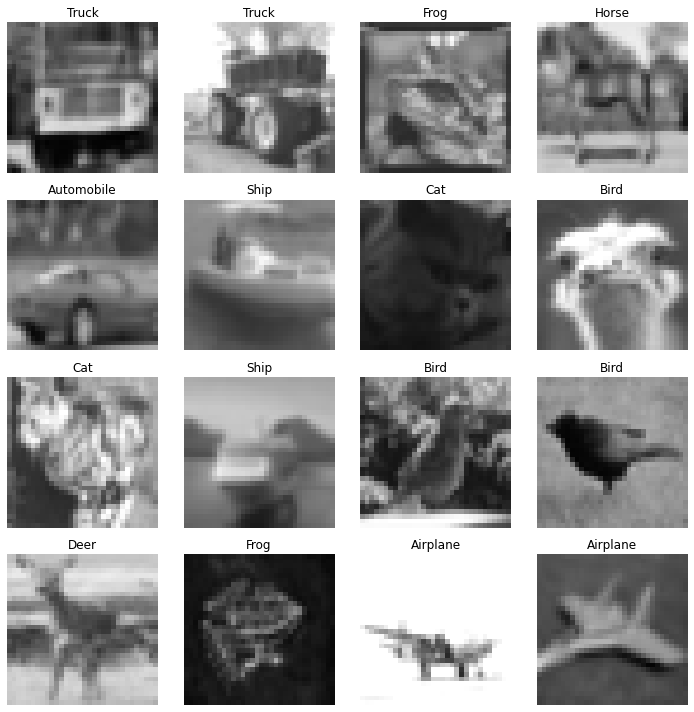

In [5]:
# visualize the images after preprocessing
from utils.data_processing import plot_preprocessed_data
plot_preprocessed_data(train_ds, cifar10_labels, num_images=16)

## 2. Feature Extraction

### 1) Building MobileNet-based feature extraction mode

In [6]:
# Import MobileNet model and modify it for our use case
model_name = 'MobileNet'

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the first 20 layers
for layer in feature_extractor.layers[:20]:
    layer.trainable = False

# Unfreeze the layers after 20
for layer in feature_extractor.layers[20:]:
    layer.trainable = True
    
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 16, 16, 32)        0     

### 2) Building custom-CNN feature extraction model

In [125]:
# Feature extraction model
feature_extractor = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])

feature_extractor.summary()

model_name = 'CustomCNN'

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               1048704   
Total params: 1,124,352
Trainable params: 1,124,352
Non-trainable params: 0
___________________________________________

In [24]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)  # transform to RGB

# use feature_extractor to extract feature
X_features = feature_extractor.predict(X_train_rgb)
print("Feature extraction completed. Shape:", X_features.shape)


Feature extraction completed. Shape: (50000, 128)


## 3. Clustering

### 1) PCA dimensionality reduction

In [25]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=50)
X_features_pca = pca.fit_transform(X_features)
print("PCA completed. Shape:", X_features_pca.shape)

PCA completed. Shape: (50000, 50)


### 2) K-means clustering to produce pseudo-code

In [26]:
# KMeans clustering
print("Performing KMeans clustering...")
n_clusters = 10  # CIFAR-10 has 10 classes
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X_features_pca)
print("KMeans clustering completed!")

Performing KMeans clustering...
KMeans clustering completed!


## 4. Pseudo-Supervised Classification

In [10]:
# add classifier top layer
# only need to run once for one model!
feature_extractor = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])

x = feature_extractor.output
output = layers.Dense(n_clusters, activation='softmax')(x)  # n_clusters 为聚类类别数

# build the complete model
model = Model(inputs=feature_extractor.input, outputs=output)

In [11]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001, decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048

In [27]:
from utils.data_processing import data_augmentation
# Manually split the training and validation datasets
total_size = len(X_train)
train_size = int(0.8 * total_size)

# Use tf.data.Dataset.take and skip to split the dataset
train_ds_cluster = tf.data.Dataset.from_tensor_slices((X_train[:train_size], cluster_labels[:train_size]))
train_ds_cluster = train_ds_cluster.map(data_augmentation).batch(256).shuffle(1000)

val_ds_cluster = tf.data.Dataset.from_tensor_slices((X_train[train_size:], cluster_labels[train_size:]))
val_ds_cluster = val_ds_cluster.map(data_augmentation).batch(256)

# Train the model
print(f"Training {model_name} model with clustering labels...")
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(train_ds_cluster, 
                    epochs=40, 
                    validation_data=val_ds_cluster, 
                    callbacks=[lr_scheduler, early_stopping])

print("Training completed!")


Training MobileNet model with clustering labels...
Epoch 1/40
157/157 [==============================] - 7s 21ms/step - loss: 4.7111 - accuracy: 0.1173 - val_loss: 2.4115 - val_accuracy: 0.2030
Epoch 2/40
157/157 [==============================] - 7s 21ms/step - loss: 2.0457 - accuracy: 0.2697 - val_loss: 1.7962 - val_accuracy: 0.3421
Epoch 3/40
157/157 [==============================] - 7s 22ms/step - loss: 1.6464 - accuracy: 0.3925 - val_loss: 1.5237 - val_accuracy: 0.4391
Epoch 4/40
157/157 [==============================] - 7s 21ms/step - loss: 1.4184 - accuracy: 0.4853 - val_loss: 1.3304 - val_accuracy: 0.5260
Epoch 5/40
157/157 [==============================] - 7s 21ms/step - loss: 1.2568 - accuracy: 0.5525 - val_loss: 1.1970 - val_accuracy: 0.5747
Epoch 6/40
157/157 [==============================] - 7s 21ms/step - loss: 1.1448 - accuracy: 0.5985 - val_loss: 1.0954 - val_accuracy: 0.6190
Epoch 7/40
157/157 [==============================] - 7s 21ms/step - loss: 1.0488 - accurac

## 5. Save & Load Model 

In [18]:
# save model
if model_name == 'MobileNet':
    model_save_path = "model/mobilenet_cluster_model.h5"
else:
    model_save_path = "model/custom_cluster_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to model/mobilenet_cluster_model.h5


In [29]:
# load MobileNet model
model_save_path = "model/mobilenet_cluster_model.h5"
model = tf.keras.models.load_model(model_save_path)
model_name = 'MobileNet'

In [33]:
# load Custom CNN model
model_save_path = "model/custom_cluster_model.h5"
model = tf.keras.models.load_model(model_save_path)
model_name = 'CustomCNN'

## 6. Evaluation

In [34]:
from utils.evaluate import evaluate_model_with_true_labels, predict_and_show_results

# Assume X_test and y_test are already loaded 
# X_test is grayscale with shape (None, 32, 32, 1)
# class_names contains the names of the classes

print(f"Using {model_name} to evaluate model performance...")

# Convert test data to match the input format required by the model
if model_name == 'MobileNet':
    # MobileNet requires RGB input, so duplicate the grayscale channel 3 times
    X_test_rgb = np.repeat(X_test, 3, axis=-1)  # Convert (32, 32, 1) -> (32, 32, 3)
    input_data = X_test_rgb
    print("Test data converted to RGB format for MobileNet.")
else:
    # For CustomCNN, grayscale input is acceptable
    input_data = X_test
    print("Test data remains in grayscale format for CustomCNN.")

# Evaluate the model on the test data with true labels
true_accuracy = evaluate_model_with_true_labels(model, input_data, y_test)
print(f"Model Accuracy on True Labels: {true_accuracy:.4f}")

# Predict and display results for a few test images
predict_and_show_results(model, input_data, y_test, cifar10_labels, num_images=10)



Using CustomCNN to evaluate model performance...
Test data remains in grayscale format for CustomCNN.
40/40 [==============================] - 2s 12ms/step - loss: 7.5810 - accuracy: 0.1209
Model Accuracy on True Labels: 0.1209
Predictions vs True Labels:
Image 1: Predicted: Dog, True: Cat
Image 2: Predicted: Ship, True: Ship
Image 3: Predicted: Airplane, True: Ship
Image 4: Predicted: Ship, True: Airplane
Image 5: Predicted: Truck, True: Frog
Image 6: Predicted: Dog, True: Frog
Image 7: Predicted: Dog, True: Automobile
Image 8: Predicted: Dog, True: Frog
Image 9: Predicted: Bird, True: Cat
Image 10: Predicted: Ship, True: Automobile


## 7. Linear Classification on Activations

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model, Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from utils.Linear_classification import get_activations, train_linear_classifier


# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

# Load trained MobileNet model
model_path = "model/mobilenet_cluster_model.h5"
model = load_model(model_path)
print("Model loaded successfully!")

# Layers to evaluate
layers = ["conv1", "conv_pw_2", "conv_pw_3", "conv_pw_4", "conv_pw_5"]  # Add more as needed
results = {}

# Evaluate each layer
for layer in layers:
    print(f"Processing layer: {layer}")
    train_activations = get_activations(model, layer, x_train)
    test_activations = get_activations(model, layer, x_test)

    # Train and evaluate classifier
    acc = train_linear_classifier(train_activations, y_train, test_activations, y_test, n_components=30)
    results[layer] = acc
    print(f"Accuracy on layer {layer}: {acc:.4f}")

print("Final results:", results)


Model loaded successfully!
Model loaded successfully!
Processing layer: conv1
Accuracy on layer conv1: 0.3820
Processing layer: conv_pw_2
Accuracy on layer conv_pw_2: 0.4665
Processing layer: conv_pw_3
Accuracy on layer conv_pw_3: 0.4930
Processing layer: conv_pw_4
Accuracy on layer conv_pw_4: 0.5900
Processing layer: conv_pw_5
Accuracy on layer conv_pw_5: 0.5970
Final results: {'conv1': 0.382, 'conv_pw_2': 0.4665, 'conv_pw_3': 0.493, 'conv_pw_4': 0.59, 'conv_pw_5': 0.597}


## 8. Visualization

### First layer visualization

Model loaded successfully!
Original images loaded.
Visualizing activations of 32 filters in layer 'conv1'
Visualization saved at: utils/images/layer_conv1_allfilters_2.png


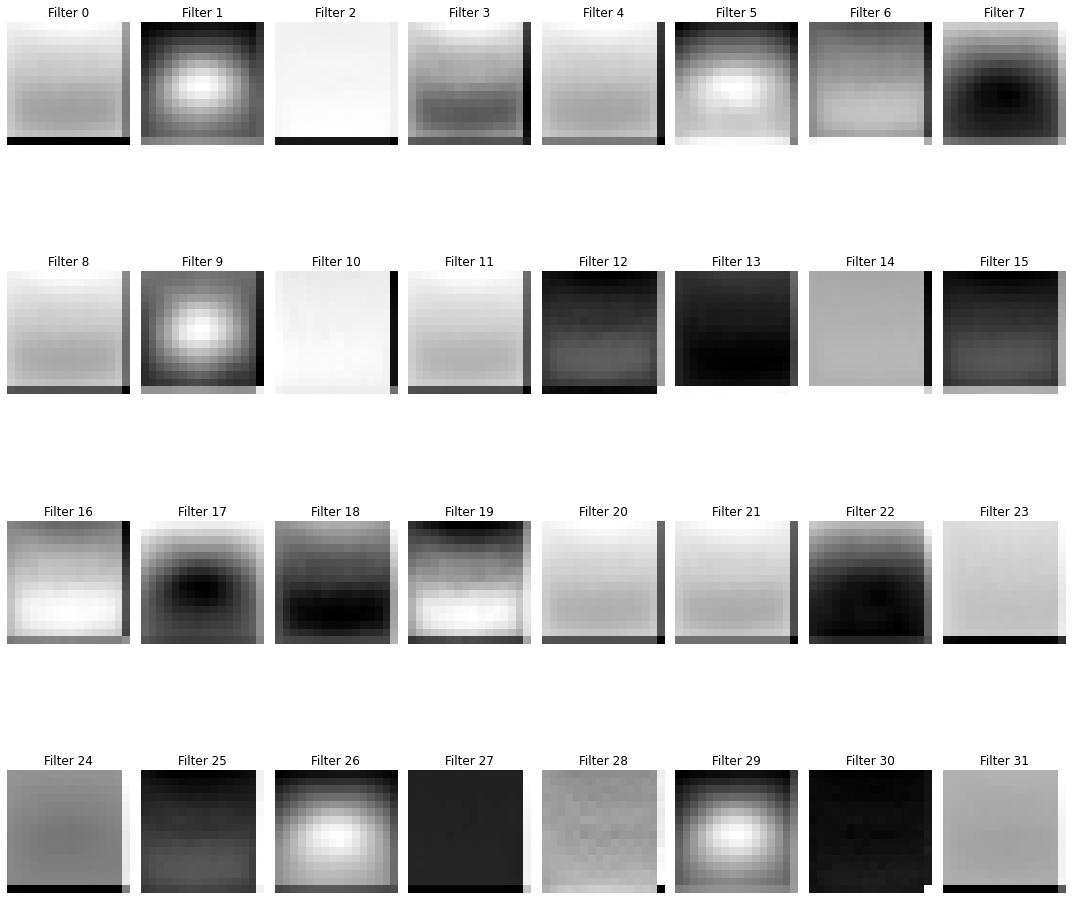

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from utils.Firstlayer_activation import load_real_images, visualize_filters_with_real_images

# Parameter settings
model_path = "model/mobilenet_cluster_model.h5"  # Model path
save_dir = "utils/images"  # Save directory path
layer_name = "conv1"  # Name of the first convolutional layer
image_size = 32  # Input image size
channels = 3  # RGB images

# Load the model
model = load_model(model_path)
print("Model loaded successfully!")

# Load real image data
images = load_real_images(image_size=image_size)
print("Original images loaded.")

# Visualize the filter responses
visualize_filters_with_real_images(model, layer_name, images, save_dir, channels=channels)

### First Layer weights visualization

No biases found in the specified layer.
Filter shape: (3, 3, 3, 32)
Number of filters: 32
Visualization saved at: utils/images/layer_conv1_allfilters_noactivate.png


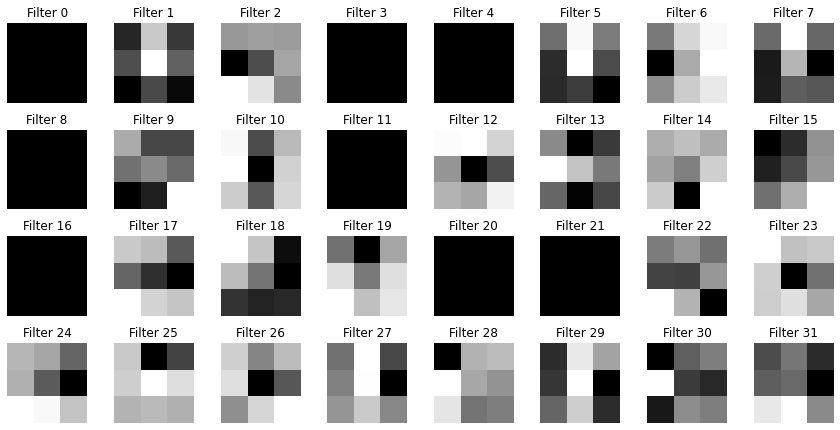

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os
from utils.Firstlayer_directweights import load_trained_model, visualize_first_layer_filters


model_path = "model/mobilenet_cluster_model.h5"  # Path to the model.
save_dir = "utils/images"  # Directory to save visualizations.
layer_name = "conv1"  # Name of the first convolutional layer.

# Load the model.
model = load_model(model_path)

# Visualize the filters of the first convolutional layer.
visualize_first_layer_filters(model, layer_name, save_dir)


###  Probing deeper layers 

#### Gradient Ascend

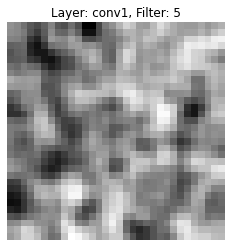

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
import random
import os
from utils.Gradient_ascend import visualize_filter


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model_path = "model/mobilenet_cluster_model.h5"  # Model path
layer_name = "conv1"  # Target convolutional layer name
filter_index = 5   # Filter index for visualization
image_size = 32  # Input image size
channels = 1  # 1 for grayscale, 3 for RGB

# Real dataset: CIFAR-10 (e.g., use the 0th image)
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train_gray = tf.image.rgb_to_grayscale(X_train)
real_image = X_train_gray[1]  # Select the first image

# Visualize results: use real data or random noise
visualize_filter(model_path, layer_name, filter_index, input_image=real_image, image_size=image_size, channels=channels, use_real_image=None)


#### Top 9 activated images

Extracting activations for layer: conv_pw_13 ...
27/27 [==============================] - 1s 14ms/step
25
Finding top 9 images for filter 5 ...


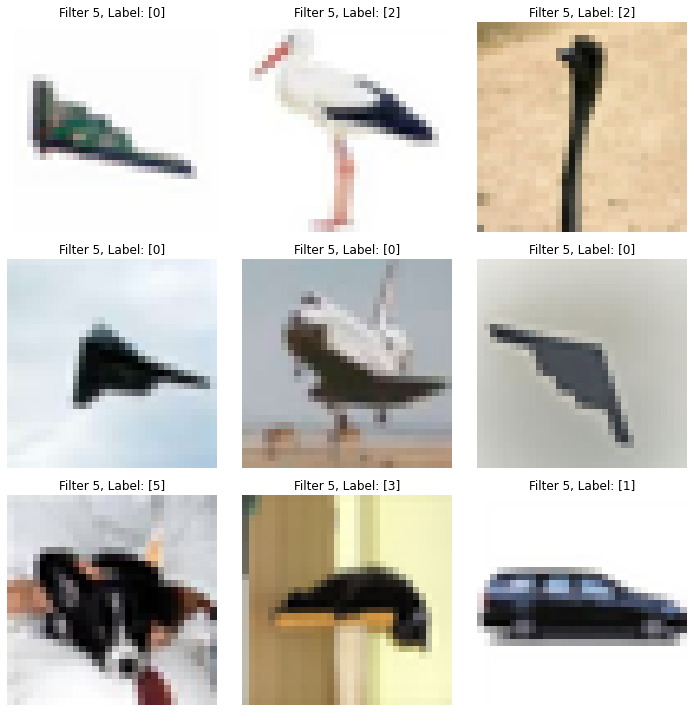

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from utils.Activation import main

model_path = "model/mobilenet_cluster_model.h5"  # Model path
layer_name = "conv_pw_13"  # Target convolutional layer name
selected_filter = 5  # Selected filter index
top_n = 9  # Number of top images to display
save_dir = "utils/images"

main(model_path, layer_name, selected_filter, top_n)
